In [259]:
%pip install TA-Lib
%pip install backtesting

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173924 sha256=6deca81d8b183cd14fbb98d492d255c6ff64672b05da97b037797505bb0f7c30
  Stored in directory: /Users/wwtlf/Library/Caches/pip/wheels/3f/7c/24/f8816cdb5359accfe50ebbb023baf41e98592f11528ed26ce6
Successfully built backtesting
Note: you may need to restart the kernel to use updated packages.


In [260]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import talib
from talib import MA_Type
import plotly.graph_objects as go
import backtesting
from backtesting import Backtest, Strategy

In [238]:
def LoadAndFill(fileName: str) -> pd.DataFrame:
    df = pd.read_csv(fileName, header=[0, 1], index_col=0)
    df.columns.names = ['Price', 'Date'] # Переименовываем индексное поле из Ticker в Date
    df.index = pd.to_datetime(df.index)
    expected_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    # missing_dates = expected_dates.difference(df.index)
    df = df.reindex(expected_dates)
    df.ffill(inplace=True)
    return df


def ScaleDF(adj_close_df: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler()
    scaled_adj_close = pd.DataFrame(
        scaler.fit_transform(adj_close_df),
        columns=adj_close_df.columns,
        index=adj_close_df.index
    )
    return scaled_adj_close


def GetClosePriceForAsset(name: str, input_df: pd.DataFrame) -> pd.DataFrame:  
    input_df = input_df[name].to_frame()
    input_df.rename(columns={name: 'Close'}, inplace=True)
    input_df.rename(columns={'index': 'Date'}, inplace=True)
    return input_df
    

In [239]:
def PlotPrices(df: pd.DataFrame):
    # Plot the scaled data
    df.plot(figsize=(12, 6), title="Нормализованная скорректированная цена закрытия")
    plt.xlabel("Дата")
    plt.ylabel("Цена от 0 до 1")
    plt.grid(True)
    plt.legend(title="Stocks", loc="upper left")
    plt.show()

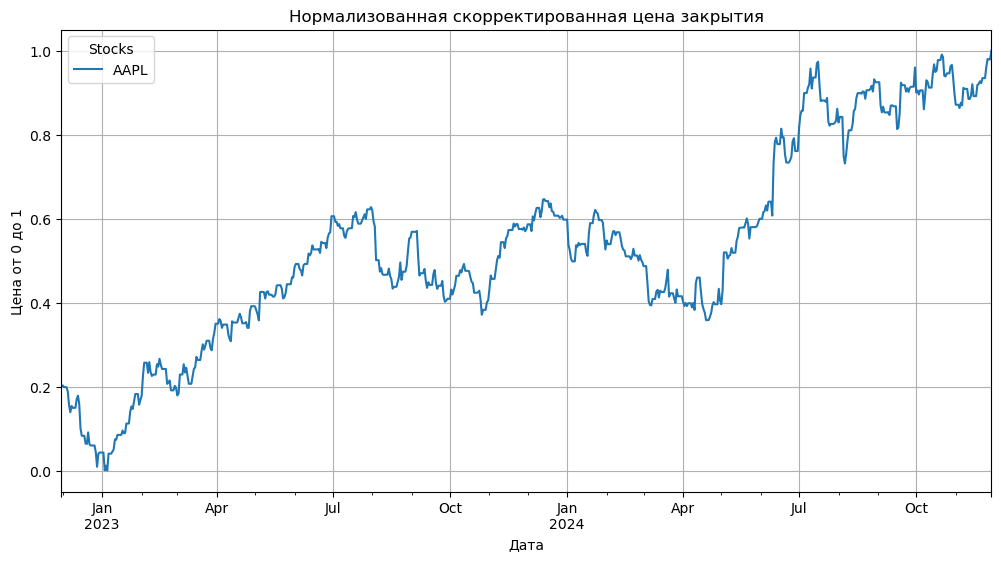

In [240]:
df = LoadAndFill('../hw7/snp500_stock_data.csv')
df = ScaleDF(df['Adj Close'])
PlotPrices(df['AAPL'])

In [241]:
df.columns

Index(['AAPL', 'AMD', 'AMZN', 'GOOG', 'IBM', 'MSFT', 'NVDA'], dtype='object', name='Date')

In [367]:
def bbands_signals(input_df: pd.DataFrame) -> pd.DataFrame:    
    period = 20
    upper, middle, lower = talib.BBANDS(input_df['Close'], matype=MA_Type.SMA, timeperiod=period)
    input_df['upper'], input_df['middle'], input_df['lower'] = upper.astype('float64'), middle.astype('float64'), lower.astype('float64')
    input_df = input_df.iloc[period-1:]
    input_df['Prev Close'] = input_df['Close'].shift(1)

    signal_df = pd.DataFrame(index=input_df.index)
    signal_df['Signal'] = 0


    # Define conditions for buy and sell signals
    buy_condition = (input_df['Prev Close'] >= input_df['lower']) & (input_df['Close'] < input_df['lower'])
    sell_condition = (input_df['Prev Close'] <= input_df['upper']) & (input_df['Close'] > input_df['upper'])
    signal_df.dropna(inplace=True)
    assert signal_df.index.equals(input_df.index), "Indices do not match"
    # Assign signals in 'signal_df'
    # Handle NaNs in conditions
    buy_condition.fillna(False)
    sell_condition.fillna(False)
    signal_df.loc[buy_condition, 'Signal'] = 1   # Buy signal
    signal_df.loc[sell_condition, 'Signal'] = -1  # Sell signal
    signal_df['Close'] = input_df['Close']
    signal_df.reset_index(inplace=True)
    signal_df.rename(columns={'index': 'Date'}, inplace=True)

    buy_sell_signals = signal_df[signal_df['Signal'] != 0]
    buy_sell_signals['prev'] = buy_sell_signals['Signal'].shift(1)

    buy_sell_signals.loc[buy_sell_signals['prev'] == buy_sell_signals['Signal'], 'Signal'] = 0    
    signal_df['Signal'] = buy_sell_signals['Signal']
    signal_df['Signal'].fillna(value=0.0, inplace=True)
    signal_df['Date'] = pd.to_datetime(signal_df['Date']) 

    return signal_df


def macd_signal(input_df: pd.DataFrame) -> pd.DataFrame:    
    # Рассчитываем TEMA и MACD
    signal_df = pd.DataFrame(index=input_df.index)
    signal_df['Close'] = input_df['Close']
    signal_df.reset_index(inplace=True)
    signal_df.rename(columns={'index': 'Date'}, inplace=True)
    signal_df['Signal'] = 0

    signal_df['tema'] = talib.TEMA(signal_df['Close'], timeperiod=24)
    signal_df['macd'], signal_df['macd_signal'], signal_df['macd_hist'] = talib.MACD(signal_df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    
    # Создаем сигналы для покупки и продажи
    signal_df['Signal'] = 0
    signal_df.loc[(signal_df['macd'] > signal_df['macd_signal']) & (signal_df['Close'] > signal_df['tema']), 'Signal'] = 1  # Сигнал на покупку
    signal_df.loc[(signal_df['macd'] < signal_df['macd_signal']) & (signal_df['Close'] < signal_df['tema']), 'Signal'] = -1  # Сигнал на продажу
    
    buy_sell_signals = signal_df[signal_df['Signal'] != 0]
    buy_sell_signals['prev'] = buy_sell_signals['Signal'].shift(1)

    buy_sell_signals.loc[buy_sell_signals['prev'] == buy_sell_signals['Signal'], 'Signal'] = 0    
    signal_df['Signal'] = buy_sell_signals['Signal']
    signal_df['Signal'].fillna(value=0.0, inplace=True)
    signal_df['Date'] = pd.to_datetime(signal_df['Date']) 

    return signal_df



In [374]:
def PlotSignal(input_signal_df: pd.DataFrame, inpit_asset_df: pd.DataFrame):
    fig = go.Figure()

    buy_signals = input_signal_df[input_signal_df['Signal'] == 1]
    sell_signals = input_signal_df[input_signal_df['Signal'] == -1]
    # Add price data
    fig.add_trace(go.Scatter(x=input_signal_df['Date'], y=input_signal_df['Close'], name='Close Price'))
    if inpit_asset_df != None:
        fig.add_trace(go.Scatter(x=inpit_asset_df.index, y=inpit_asset_df['upper'], name='Upper'))
        fig.add_trace(go.Scatter(x=inpit_asset_df.index, y=inpit_asset_df['lower'], name='lower'))


    # Add buy signals
    fig.add_trace(go.Scatter(
        x=buy_signals['Date'],
        y=buy_signals['Close'],
        mode='markers',
        name='Buy Signal',
        marker_symbol='triangle-up',
        marker_color='green',
        marker_size=10
    ))

    # Add sell signals
    fig.add_trace(go.Scatter(
        x=sell_signals['Date'],
        y=sell_signals['Close'],
        mode='markers',
        name='Sell Signal',
        marker_symbol='triangle-down',
        marker_color='red',
        marker_size=10
    ))

    # Update layout
    fig.update_layout(
        title='Bollinger Bands with Buy and Sell Signals',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False
    )

    fig.show()

In [331]:
apple_df = GetClosePriceForAsset('AAPL', df)
apple_df

,Close
2022-11-30,0.200426
2022-12-01,0.202864
2022-12-02,0.198509
2022-12-03,0.198509
2022-12-04,0.198509
...,...
2024-11-25,0.960743
2024-11-26,0.980020
2024-11-27,0.978875
2024-11-28,0.978875


In [332]:
signal_df = bbands_signals(apple_df)
signal_df.head(20)

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/1668699706.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/1668699706.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Signal,Close
0,2022-12-19,0.0,0.064021
1,2022-12-20,0.0,0.063411
2,2022-12-21,0.0,0.090849
3,2022-12-22,0.0,0.062802
4,2022-12-23,0.0,0.059579
5,2022-12-24,0.0,0.059579
6,2022-12-25,0.0,0.059579
7,2022-12-26,0.0,0.059579
8,2022-12-27,0.0,0.043639
9,2022-12-28,0.0,0.008885


In [333]:
PlotSignal(signal_df, apple_df)

In [ ]:
amazon_df = GetClosePriceForAsset('AMZN', df)
amazon_signal_df = bbands_signals(amazon_df)


/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/203180275.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/203180275.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Signal,Close
0,2022-12-19,0.0,0.023435
1,2022-12-20,0.0,0.025476
2,2022-12-21,0.0,0.037421
3,2022-12-22,0.0,0.014893
4,2022-12-23,0.0,0.025930
...,...,...,...
707,2024-11-25,0.0,0.904369
708,2024-11-26,0.0,0.952827
709,2024-11-27,0.0,0.936801
710,2024-11-28,0.0,0.936801


In [ ]:
class SimpleFollowSignalsStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda: self.data.Signal)
        self.previous_signal = 0

    def next(self):
        current_signal = self.signal[-1]      
        if current_signal == 1:
            if self.position.is_short:
                self.position.close()
                return
                
            if not self.position.is_long:
                self.buy()
                
        elif current_signal == -1:
            if self.position.is_long:
                self.position.close()
                return
                
            if not self.position.is_short:
                self.sell()   
        else:
            return  

        self.previous_signal = current_signal

In [336]:
signal_df['Open'], signal_df['High'], signal_df['Low'] = signal_df['Close'], signal_df['Close'], signal_df['Close']
# signal_df['Signal'] = signal_df['Signal'] * -1
signal_df

,Date,Signal,Close,Open,High,Low
0,2022-12-19,0.0,0.064021,0.064021,0.064021,0.064021
1,2022-12-20,0.0,0.063411,0.063411,0.063411,0.063411
2,2022-12-21,0.0,0.090849,0.090849,0.090849,0.090849
3,2022-12-22,0.0,0.062802,0.062802,0.062802,0.062802
4,2022-12-23,0.0,0.059579,0.059579,0.059579,0.059579
...,...,...,...,...,...,...
707,2024-11-25,-1.0,0.960743,0.960743,0.960743,0.960743
708,2024-11-26,0.0,0.980020,0.980020,0.980020,0.980020
709,2024-11-27,0.0,0.978875,0.978875,0.978875,0.978875
710,2024-11-28,0.0,0.978875,0.978875,0.978875,0.978875


In [337]:
PlotSignal(signal_df, apple_df)

In [ ]:
bt = Backtest(signal_df, SimpleFollowSignalsStrategy, cash=1, commission=.002, exclusive_orders=True)

# Запускаем бэктест
stats = bt.run()

# Выводим статистику
print(stats['Return [%]'])

# выводим график
bt.plot(
    plot_equity=True,
    plot_drawdown=True,
    relative_equity=False,
)

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/291553904.py:1: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Users/wwtlf/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:149: RuntimeWarning:

invalid value encountered in true_divide



3657.90561803382


Row(id='29720', ...)

In [339]:
PlotSignal(amazon_signal_df, amazon_df)

In [ ]:
amazon_signal_df['Date'] = pd.to_datetime(amazon_signal_df['Date']) 
amazon_signal_df['Open'], amazon_signal_df['High'], amazon_signal_df['Low'] = amazon_signal_df['Close'],amazon_signal_df['Close'],amazon_signal_df['Close']
# amazon_signal_df['Signal'] = amazon_signal_df['Signal'] * -1
bt = Backtest(amazon_signal_df, SimpleFollowSignalsStrategy, cash=1, commission=.002, exclusive_orders=True)
# Запускаем бэктест
stats = bt.run()

# Выводим статистику
print(stats['Return [%]'])

# выводим график
bt.plot(
    plot_equity=True,
    plot_drawdown=True,
    relative_equity=False,
)

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/1276440471.py:4: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Users/wwtlf/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:149: RuntimeWarning:

invalid value encountered in true_divide



-100.0


Row(id='30898', ...)

In [ ]:
apple_df = GetClosePriceForAsset('AAPL', df)
macd_apple_df = macd_signal(apple_df)
# macd_apple_df
PlotSignal(macd_apple_df, None)
macd_apple_df['Open'], macd_apple_df['High'], macd_apple_df['Low'] = macd_apple_df['Close'],macd_apple_df['Close'],macd_apple_df['Close']
# amazon_signal_df['Signal'] = amazon_signal_df['Signal'] * -1
bt = Backtest(macd_apple_df, SimpleFollowSignalsStrategy, cash=1, commission=.002, exclusive_orders=True)
# Запускаем бэктест
stats = bt.run()

# Выводим статистику
print(stats['Return [%]'])

# выводим график
bt.plot(
    plot_equity=True,
    plot_drawdown=True,
    relative_equity=False,
)

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/44020826.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/686232706.py:7: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Users/wwtlf/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:149: RuntimeWarning:

invalid value encountered in true_divide



60.7928379023778


Row(id='32076', ...)

In [ ]:
amazon_df_df = GetClosePriceForAsset('AMZN', df)
macd_amazon_df = macd_signal(amazon_df_df)
# macd_apple_df
PlotSignal(macd_amazon_df, None)

macd_amazon_df['Open'], macd_amazon_df['High'], macd_amazon_df['Low'] = macd_amazon_df['Close'],macd_amazon_df['Close'],macd_amazon_df['Close']
# macd_amazon_df['Signal'] = macd_amazon_df['Signal'] * -1
# amazon_signal_df['Signal'] = amazon_signal_df['Signal'] * -1
bt = Backtest(macd_amazon_df, SimpleFollowSignalsStrategy, cash=1, commission=.002, exclusive_orders=True)
# Запускаем бэктест
stats = bt.run()

# Выводим статистику
print(stats['Return [%]'])

# выводим график
bt.plot(
    plot_equity=True,
    plot_drawdown=True,
    relative_equity=False,
)

/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/44020826.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/sv/9l0r_c9d3bz0y61h_1q79r2c0000gn/T/ipykernel_82266/326910320.py:9: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Users/wwtlf/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:149: RuntimeWarning:

invalid value encountered in true_divide



-74.23141159076201


Row(id='34432', ...)

-74.23141159076201